# Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time

import torch
import torchvision
from torchvision import datasets, transforms

from IPython.display import clear_output

# Data Loading

In [2]:
#settings
batch_size = 100
test_batch_size = 20

# load data
kwargs = {}
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('data', train=True, download=True,
                    transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('data', train=False, transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])),
    batch_size=test_batch_size, shuffle=True, **kwargs)

###################################################################################################àà

xtrain = train_loader.dataset.data.numpy().reshape(-1, batch_size, 784) / 256
ytrain = train_loader.dataset.targets.numpy().reshape(-1, batch_size)

xtest = test_loader.dataset.data.numpy().reshape(-1, test_batch_size, 784) / 256
ytest = test_loader.dataset.targets.numpy().reshape(-1, test_batch_size)

###################################################################################################

''' negative targets [-1, -1, +1, ... -1] '''

ytrain_neg = np.ones((ytrain.shape[0], ytrain.shape[1], 10)) * -1
for i, batch in enumerate(ytrain):
    for j, target in enumerate(batch):
        ytrain_neg[i, j, target] = 1
        
print(ytrain_neg.shape)
print(ytrain_neg[0, 0])

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw
Processing...



Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


(600, 100, 10)
[-1. -1. -1. -1. -1.  1. -1. -1. -1. -1.]


# Simple ANN binarization

## ANN 1 

In [ ]:
class ANN:
    def __init__(self, dim_in, dim_hid, dim_out, lr, activation='sigmoid', shift=False):
        
        # hyperparameters:
        self.dim_in = dim_in
        self.dim_hid = dim_hid
        self.dim_out = dim_out
        self.lr = lr
        
        self.set_activation(activation)   
        
        # parameters:
        self.weightsIH = np.random.normal(0, 0.01, size=(self.dim_hid, self.dim_in))
        self.weightsHO = np.random.normal(0, 0.01, size=(self.dim_out, self.dim_hid))
        
        # variables
        self.x  = np.zeros(self.dim_in)
        
        self.zh = np.zeros(self.dim_hid)
        self.ah = np.zeros(self.dim_hid)
        
        self.zo = np.zeros(self.dim_out)
        self.ao = np.zeros(self.dim_out)
        
        self.loss = np.zeros(self.dim_out)
        self.lossDo = np.zeros(self.dim_out)
        self.lossDh = np.zeros(self.dim_hid)
        
        # targets
        if shift:
            self.y_train = ytrain_neg
        else:
            self.y_train = ytrain
        
    def set_activation(self, flag='sigmoid'):
        
        if flag == 'sigmoid':
            self.activation_function = lambda x: 1 / (1 + np.exp(-x))
            self.activation_function_prime = lambda x: self.activation_function(x) * (1 - self.activation_function(x))
        
        elif flag == 'tanh':
            self.activation_function = lambda x: (np.exp(x) - np.exp(-x)) / (np.exp(x) + np.exp(-x))
            self.activation_function_prime = lambda x: 1 - self.activation_function(x) ** 2
            
        else:
            self.activation_function = lambda x: x
            self.activation_function_prime = lambda x: x
            
    def get_parameters(self):
        return {'IH': self.weightsIH,
                'HO': self.weightsHO,
                'shape': (self.dim_in, self.dim_hid, self.dim_out)}
    
        
    def forward(self, X):
        self.x = X.T

        self.zh = np.dot(self.weightsIH, self.x)
        self.ah = self.activation_function(self.zh)
        self.zo = np.dot(self.weightsHO, self.ah)
        self.ao = self.activation_function(self.zo)
        
        
    def backward(self, Y):
        self.loss = (Y - self.ao) ** 2
        
        self.lossDo = (self.ao - Y) * self.activation_function_prime(self.zo)
        self.lossDh = np.dot(self.weightsHO.T, np.reshape(self.lossDo, (self.dim_out, batch_size))) * np.reshape(
            self.activation_function_prime(self.zh), (self.dim_hid, batch_size))
        
        self.weightsIH -= self.lr * np.dot(self.lossDh, self.x.T)

        self.weightsHO -= self.lr * np.dot(self.lossDo, self.ah.T)
    
    def accuracy(self):
                
        corrects = 0
        for x, y in zip(xtest, ytest):
            self.forward(x)
            corrects += np.mean(y == np.argmax(self.ao, axis=0))
            
        return np.around(100*corrects/len(xtest), 1)
        
        
    def train(self, epochs=1):        
        
        # pre-training accuracy        
        pre_acc = self.accuracy()
        print('pre-training accuracy: ', pre_acc, '%')
        
        ''' training '''
        
        losses = []
        test_acc = 0
        
        for epoch in range(epochs):
            
            clear_output(wait=True)
            for i, x, y in zip(range(len(xtrain)), xtrain, self.y_train):
                self.forward(x)
                self.backward(y.T)
                    
                if i%100 == 0:
                    clear_output(wait=True)
                    print(f'epoch: {epoch+1}|{epochs}\ntest accuracy: {test_acc}%')
                    print(f'\ndata {100*i/len(xtrain):.0f}%')
                        
            losses.append(np.mean(self.loss))
            
            
            ''' test '''
            
            test_acc = self.accuracy()  
            
           
        clear_output(wait=True)
        print('\nTRAINING ENDED\n')
        print('classes: {}\nepochs done: {}\n\npre_training accuracy: {}%\ntest accuracy: {}%'.format(
                                                                    self.dim_out, epochs, pre_acc, test_acc))                  
    

### run 1 | with sigmoid 

In [ ]:
ni, nh, no = 784, 64, 10

ann_1s = ANN(dim_in=ni, dim_hid=nh, dim_out=no, lr=0.001, activation='sigmoid')

''' run '''

ann_1s.train(epochs=20)


TRAINING ENDED

classes: 10
epochs done: 20

pre_training accuracy: 11.3%
test accuracy: 90.0%


### run 2 | with tanh + y_neg

y_neg -> target shift

target vector: [-1, -1, +1, -1]

In [ ]:
ann_1t = ANN(dim_in=ni, dim_hid=nh, dim_out=no, lr=0.001, activation='tanh', shift=True)

''' run '''

ann_1t.train(epochs=20)


TRAINING ENDED

classes: 10
epochs done: 20

pre_training accuracy: 15.2%
test accuracy: 96.8%


## ANN 2 | clipper weights (+- bound)

bounded (clipped) weights  -> not much difference

In [ ]:
class ANN_2:
    def __init__(self, dim_in, dim_hid, dim_out, lr, bound=6., activation='sigmoid', shift=False):
        
        # hyperparameters:
        self.dim_in = dim_in
        self.dim_hid = dim_hid
        self.dim_out = dim_out
        self.lr = lr
        
        self.set_activation(activation)
        
        # parameters:
        self.weightsIH = np.random.normal(0, 0.01, size=(self.dim_hid, self.dim_in))
        self.weightsHO = np.random.normal(0, 0.01, size=(self.dim_out, self.dim_hid))
        
        # variables
        self.x  = np.zeros(self.dim_in)
        
        self.zh = np.zeros(self.dim_hid)
        self.ah = np.zeros(self.dim_hid)
        
        self.zo = np.zeros(self.dim_out)
        self.ao = np.zeros(self.dim_out)
        
        self.loss = np.zeros(self.dim_out)
        self.lossDo = np.zeros(self.dim_out)
        self.lossDh = np.zeros(self.dim_hid)
        
        self.bound = bound
        
        # targets
        if shift:
            self.y_train = ytrain_neg
        else:
            self.y_train = ytrain
            
        
    def set_activation(self, flag='sigmoid'):
        
        if flag == 'sigmoid':
            self.activation_function = lambda x: 1 / (1 + np.exp(-x))
            self.activation_function_prime = lambda x: self.activation_function(x) * (1 - self.activation_function(x))
        
        elif flag == 'tanh':
            self.activation_function = lambda x: (np.exp(x) - np.exp(-x)) / (np.exp(x) + np.exp(-x))
            self.activation_function_prime = lambda x: 1 - self.activation_function(x) ** 2
            
        else:
            self.activation_function = lambda x: x
            self.activation_function_prime = lambda x: x
        
        
    def get_parameters(self):
        return {'IH': self.weightsIH,
                'HO': self.weightsHO,
                'shape': (self.dim_in, self.dim_hid, self.dim_out)}
    
    
    def bound_function(self, u):
        return np.clip(u, -self.bound, self.bound)
    
        
    def forward(self, X):
        self.x = X.T

        self.zh = np.dot(self.weightsIH, self.x)
        self.ah = self.activation_function(self.zh)
        self.zo = np.dot(self.weightsHO, self.ah)
        self.ao = self.activation_function(self.zo)
        
        
    def backward(self, Y):
        self.loss = (Y - self.ao) ** 2
        
        self.lossDo = (self.ao - Y) * self.activation_function_prime(self.zo)
        self.lossDh = np.dot(self.weightsHO.T, np.reshape(self.lossDo, (self.dim_out, batch_size))) * np.reshape(
            self.activation_function_prime(self.zh), (self.dim_hid, batch_size))
        
        self.weightsIH -= self.lr * self.bound_function(np.dot(self.lossDh, self.x.T))

        self.weightsHO -= self.lr * self.bound_function(np.dot(self.lossDo, self.ah.T))
    
    
    def accuracy(self):
                
        corrects = 0
        for x, y in zip(xtest, ytest):
            self.forward(x)
            corrects += np.mean(y == np.argmax(self.ao, axis=0))
            
        return np.around(100*corrects/len(xtest), 1)
        
        
    def train(self, epochs=1, shift=0):        
        
        # pre-training accuracy        
        pre_acc = self.accuracy()
        print('pre-training accuracy: ', pre_acc, '%')
        
        ''' training '''
        
        losses = []
        test_acc = 0
        
        for epoch in range(epochs):
            
            clear_output(wait=True)
            for i, x, y in zip(range(len(xtrain)), xtrain, self.y_train):
                self.forward(x)
                self.backward(y.T)
                    
                if i%100 == 0:
                    clear_output(wait=True)
                    print(f'epoch: {epoch+1}|{epochs}\ntest accuracy: {test_acc}%')
                    print(f'\ndata {100*i/len(xtrain):.0f}%')
                        
            losses.append(np.mean(self.loss))
            
            
            ''' test '''
            
            test_acc = self.accuracy()      
           
        clear_output(wait=True)
        print('\nTRAINING ENDED\n')
        print('classes: {}\nepochs done: {}\n\npre_training accuracy: {}%\ntest accuracy: {}%'.format(
                                                                    self.dim_out, epochs, pre_acc, test_acc))                  
    

### run 3 | tanh + y_neg + weight bound

In [ ]:
ann_2 = ANN_2(dim_in=ni, dim_hid=nh, dim_out=no, lr=0.001, bound=1, activation='tanh', shift=True)

''' run '''

ann_2.train(epochs=20)


TRAINING ENDED

classes: 10
epochs done: 20

pre_training accuracy: 7.7%
test accuracy: 96.1%


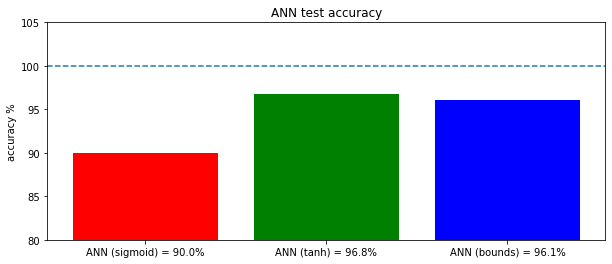

In [ ]:
bar_colors = ['red', 'green', 'blue']

fig = plt.figure(figsize=(10, 4))
a1, a2, a3 = (ann_1s.accuracy(), ann_1t.accuracy(), ann_2.accuracy())

plt.bar((0, 1, 2), (a1, a2, a3), color=bar_colors)
plt.xticks((0, 1, 2), (f'ANN (sigmoid) = {a1:.1f}%', f'ANN (tanh) = {a2:.1f}%', f'ANN (bounds) = {a3:.1f}%'))
plt.ylim((80, 105))
plt.axhline(100, linestyle='--')
plt.ylabel('accuracy %')
plt.title('ANN test accuracy')

plt.show()

## BNN
BNN network obtained by plain binarization of the ANN parameters

In [3]:
class BNN:
    def __init__(self, ann_params, bias=0, amax=True):
        
        # hyperparameters:
        self.dim_in = ann_params['shape'][0]
        self.dim_hid = ann_params['shape'][1]
        self.dim_out = ann_params['shape'][2]
        
        # use of argmax in the computation of the output
        self.amax = amax

        self.activation_function = lambda s: np.sign(s).astype(int)
        
        # obtain the binary parameters:
        self.weightsIH = self.binarize(ann_params['IH'].copy(), bias)
        self.weightsHO = self.binarize(ann_params['HO'].copy(), bias)
        
        # variables
        self.x  = np.zeros(self.dim_in)
        
        self.zh = np.zeros(self.dim_hid)
        self.ah = np.zeros(self.dim_hid)
        
        self.zo = np.zeros(self.dim_out)
        self.ao = np.zeros(self.dim_out)
        
        # data
        self.test_data = 0
        self.zerout = np.zeros(self.dim_out)
        
        
    def binarize(self, w, bias=0): # <--------------------------  binarization happens here
        return np.where(w >= bias, 1, -1)
        
        
    def forward(self, X):
        self.x = X.T

        self.zh = np.dot(self.weightsIH, self.x)
        self.ah = self.activation_function(self.zh)
        self.zo = np.dot(self.weightsHO, self.ah)
        if self.amax:
            self.ao = np.argmax(self.zo, axis=0)
        else:
            self.ao = self.activation_function(self.zo)  # i.e. sign function
        
    def accuracy(self):
                
        corrects = 0
        for x, y in zip(xtest, ytest):
            self.forward(x)
            if self.amax:
                corrects += np.mean(y == self.ao, axis=0)
            else:
                corrects += np.mean(y == np.argmax(self.ao, axis=0))
            
        return np.around(100*corrects/len(xtest), 1)
        

In [ ]:
# BNN with argmax
bnn_1s_a = BNN(ann_params=ann_1s.get_parameters())
bnn_1t_a = BNN(ann_params=ann_1t.get_parameters())
bnn_2_a = BNN(ann_params=ann_2.get_parameters())

# BNN without argmax
bnn_1s = BNN(ann_params=ann_1s.get_parameters(), amax=False)
bnn_1t = BNN(ann_params=ann_1t.get_parameters(), amax=False)
bnn_2 = BNN(ann_params=ann_2.get_parameters(), amax=False)

models = (ann_1s, ann_1t, ann_2, bnn_1s_a, bnn_1t_a, bnn_2_a, bnn_1s, bnn_1t, bnn_2)
names = ('ANN sigm', 'ANN tanh', 'ANN boun', 'BNN sigm (A)', 'BNN tanh (A)', 'BNN boun (A)', 'BNN sigm', 'BNN tanh', 'BNN boun')

for idx, model, name in zip(range(len(models)), models, names):
    if idx == 3 or idx == 6:
        print()
    print(f'{name} accuracy: {model.accuracy()}%')

ANN sigm accuracy: 90.0%
ANN tanh accuracy: 96.8%
ANN boun accuracy: 96.1%

BNN sigm (A) accuracy: 78.5%
BNN tanh (A) accuracy: 53.6%
BNN boun (A) accuracy: 8.9%

BNN sigm accuracy: 23.9%
BNN tanh accuracy: 30.0%
BNN boun accuracy: 8.9%


##### plot with argmax

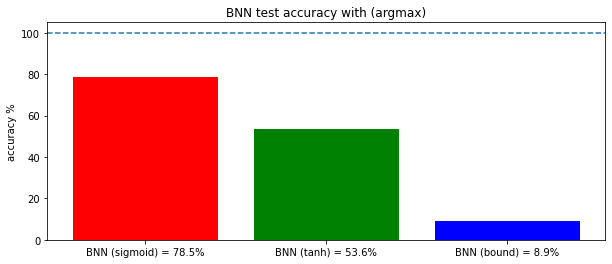

In [ ]:
fig = plt.figure(figsize=(10, 4))
b1, b2, b3 = (bnn_1s_a.accuracy(), bnn_1t_a.accuracy(), bnn_2_a.accuracy())

plt.bar((0, 1, 2), (b1, b2, b3), color=bar_colors)
plt.xticks((0, 1, 2), (f'BNN (sigmoid) = {b1:.1f}%', f'BNN (tanh) = {b2:.1f}%', f'BNN (bound) = {b3:.1f}%'))
plt.ylim((0, 105))
plt.axhline(100, linestyle='--')
plt.ylabel('accuracy %')
plt.title('BNN test accuracy with (argmax)')

plt.show()

##### plot without argmax

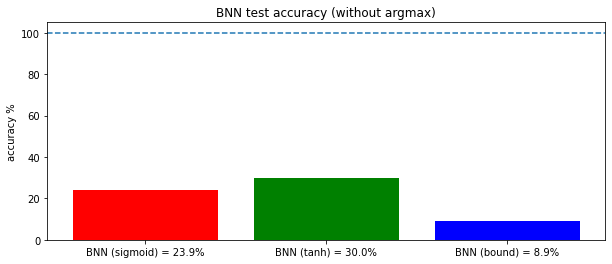

In [ ]:
fig = plt.figure(figsize=(10, 4))
b1, b2, b3 = (bnn_1s.accuracy(), bnn_1t.accuracy(), bnn_2.accuracy())

plt.bar((0, 1, 2), (b1, b2, b3), color=bar_colors)
plt.xticks((0, 1, 2), (f'BNN (sigmoid) = {b1:.1f}%', f'BNN (tanh) = {b2:.1f}%', f'BNN (bound) = {b3:.1f}%'))
plt.ylim((0, 105))
plt.axhline(100, linestyle='--')
plt.ylabel('accuracy %')
plt.title('BNN test accuracy (without argmax)')

plt.show()

## Concordance test

test the fulfillment of the sign condition on the hidden and output activations

$sign(\sum x) = sign(\sum sign(x))$

In [4]:
def concordance(x):
    return np.mean(np.sign(np.sum(x, axis=0)) == np.sign(np.sum(np.sign(x), axis=0)))

In [5]:
def accuracy_conc(model, name):
    
    score_ah = 0
    score_ao = 0
    
    for x in xtest:
    
        model.forward(x)
        score_ah += concordance(model.ah)
        score_ao += concordance(model.ao)
                
    print(f'\n{name} concordance score hidden layer: {np.around(100*score_ah/len(xtest), 2)}%')
    print(f'{name} concordance score output layer: {np.around(100*score_ao/len(xtest), 2)}%')

In [ ]:
for idx, model, name in zip(range(len(models)), models, names):
    if idx == 5:
        print()
    accuracy_conc(model=model, name=name)


ANN sigm concordance score hidden layer: 100.0%
ANN sigm concordance score output layer: 100.0%

ANN tanh concordance score hidden layer: 88.21%
ANN tanh concordance score output layer: 100.0%

ANN boun concordance score hidden layer: 99.99%
ANN boun concordance score output layer: 100.0%

BNN sigm (A) concordance score hidden layer: 100.0%
BNN sigm (A) concordance score output layer: 100.0%

BNN tanh (A) concordance score hidden layer: 100.0%
BNN tanh (A) concordance score output layer: 100.0%


BNN boun (A) concordance score hidden layer: 100.0%
BNN boun (A) concordance score output layer: 100.0%

BNN sigm concordance score hidden layer: 100.0%
BNN sigm concordance score output layer: 100.0%

BNN tanh concordance score hidden layer: 100.0%
BNN tanh concordance score output layer: 100.0%

BNN boun concordance score hidden layer: 100.0%
BNN boun concordance score output layer: 100.0%


# Binary Regularization algorithm

binary regularization -> force the weights to stay close to binary values during the update

$W_{t+1} = W_{t} - \eta \dot \nabla L + \beta R$ 

## ANN 3

it uses the following definition of R

$R \doteq sign(W)\odot \phi (\omega - |W|)$

In [6]:
class ANN_3:
    def __init__(self, dim_in, dim_hid, dim_out, lr, beta=0.5, omega=6., activation='sigmoid', shift=True):
        
        # hyperparameters:
        self.dim_in = dim_in
        self.dim_hid = dim_hid
        self.dim_out = dim_out
        self.lr = lr
        
        self.set_activation(activation)    
        
        # parameters:
        self.weightsIH = (np.random.binomial(1, 0.5, size=(self.dim_hid, self.dim_in)).astype(float) - 0.5) / 5
        self.weightsHO = (np.random.binomial(1, 0.5, size=(self.dim_out, self.dim_hid)).astype(float) - 0.5) / 5
        
        # variables
        self.x  = np.zeros(self.dim_in)
        
        self.zh = np.zeros(self.dim_hid)
        self.ah = np.zeros(self.dim_hid)
        
        self.zo = np.zeros(self.dim_out)
        self.ao = np.zeros(self.dim_out)
        
        self.loss = np.zeros(self.dim_out)
        self.lossDo = np.zeros(self.dim_out)
        self.lossDh = np.zeros(self.dim_hid)
        
        # loss
        self.beta = beta
        self.omega = omega
        
        self.gradIH = np.zeros_like(self.weightsIH)
        self.gradHO = np.zeros_like(self.weightsHO)
        
        # targets
        if shift:
            self.y_train = ytrain_neg
        else:
            self.y_train = ytrain
            
        
    def set_activation(self, flag='sigmoid'):
        
        if flag == 'sigmoid':
            self.activation_function = lambda x: 1 / (1 + np.exp(-x))
            self.activation_function_prime = lambda x: self.activation_function(x) * (0.05 - self.activation_function(x))
        
        elif flag == 'tanh':
            self.activation_function = lambda x: 2 / (1 + np.exp(-x)) - 1
            self.activation_function_prime = lambda x: 1 - self.activation_function(x) ** 2
            
        elif flag == 'bounded':
            self.activation_function = lambda x: np.clip(x, -self.omega, self.omega)
            self.activation_function_prime = np.vectorize(lambda x: 1*(-self.omega < x and x < self.omega))
            
        else:
            self.activation_function = lambda x: x
            self.activation_function_prime = lambda x: x
    
    
    def get_parameters(self):
        return {'IH': self.weightsIH,
                'HO': self.weightsHO,
                'shape': (self.dim_in, self.dim_hid, self.dim_out)}
    
        
    def forward(self, X):
        self.x = X.T

        self.zh = np.dot(self.weightsIH, self.x)
        self.ah = self.activation_function(self.zh)
        self.zo = np.dot(self.weightsHO, self.ah)
        self.ao = self.activation_function(self.zo)
        
    
    def bound_function(self, u):
        '''
        for now no better function has been found
        '''
        return u
    
    def backward(self, Y):

        # losses
        self.loss = (Y - self.ao) ** 2
        
        self.lossDo = (self.ao - Y) * self.activation_function_prime(self.zo)
        self.lossDh = np.dot(self.weightsHO.T, np.reshape(self.lossDo, (self.dim_out, batch_size))) * np.reshape(
            self.activation_function_prime(self.zh), (self.dim_hid, batch_size))
        
        # gradients
        self.gradIH = np.dot(self.lossDh, self.x.T)
        self.gradHO = np.dot(self.lossDo, self.ah.T)
        
        
        # updates
        self.weightsIH -= self.lr * self.gradIH - self.beta * np.sign(self.weightsIH
                                            ) * (self.omega - np.abs(self.weightsIH))

        self.weightsHO -= self.lr * self.gradHO - self.beta * np.sign(self.weightsHO
                                            ) * self.bound_function(self.omega - np.abs(self.weightsHO))

        
        
    def show_w(self, epoch, acc, binary=False):

        clear_output(wait=True)

        names = ('input', 'output')
        plt.clf()
        for j, col in enumerate((self.weightsIH, self.weightsHO)):

            plt.subplot(1, 2, j+1)
            n, bins, patches = plt.hist(col.flatten(), bins=50, density=True, facecolor='g', alpha=0.75)


            plt.xlabel(f'weights {names[j]}')
            plt.ylabel('quantity')

            plt.axis([-self.bound-0.2, self.bound+0.2, 0, 30.])
        plt.title(f'data: {epoch:.1f}% - accuracy: {acc}%')
            
        plt.pause(0.00001)
    
        
    def accuracy(self):
                
        corrects = 0
        for x, y in zip(xtest, ytest):
            self.forward(x)
            corrects += np.mean(y == np.argmax(self.ao, axis=0))
            
        return np.around(100*corrects/len(xtest), 1)
        
        
    def train(self, epochs=1, display=False, verbose=True):        
        
        # pre-training accuracy        
        pre_acc = self.accuracy()
        
        ''' training '''
        
        losses = []
        test_acc = 0
        
        for epoch in range(epochs):
            
            
            for i, x, y in zip(range(len(xtrain)), xtrain, self.y_train):
                
                self.forward(x)
                self.backward(y.T)
                    
                if i%100 == 0 and not display and verbose:
                    clear_output(wait=True)
                    print(f'epoch: {epoch+1}|{epochs}\ntest accuracy: {test_acc}%')
                    print(f'\ndata {100*i/len(xtrain):.0f}%')
                    pass
                    
                if display and i%100 == 0:
                    self.show_w(100*i/len(xtrain), test_acc)
                        
            losses.append(np.mean(self.loss))
            
            
            ''' test '''
            
            test_acc = self.accuracy()  
                
        plt.pause(1)
    
           
        if verbose:
            clear_output(wait=True)
            print('\nTRAINING ENDED\n')
            print('epochs done: {}\n\nANN accuracy: {}%'.format(epochs, test_acc))                  
    

#### run with quasi-binary weights

In [ ]:
ann_3 = ANN_3(dim_in=ni, dim_hid=nh, dim_out=no, lr=0.001, beta=0.001, omega=0.1, activation='tanh', shift=True)

''' run '''

ann_3.train(epochs=20, display=0, verbose=1)


''' binarized '''

bnn_3 = BNN(ann_params=ann_3.get_parameters(), amax=False)

print(f'BNN accuracy: {bnn_3.accuracy()}%')


TRAINING ENDED

epochs done: 20

ANN accuracy: 93.3%
BNN accuracy: 57.0%


#### varying the bounds

In [ ]:
omega_set = np.around(np.linspace(0.001, 1.1, 20), 5)
n = len(bound_set)
accuracies_ann = np.zeros(n)
accuracies_bnn = np.zeros(n)

for i, bound in enumerate(bound_set):
    
    print(f'processed {100*i/n:.1f}%')
    mod_a = ANN_3(dim_in=ni, dim_hid=nh, dim_out=no, lr=0.001, beta=0.001, omega=omega, activation='tanh', shift=True)
    mod_a.train(epochs=5, display=False, verbose=False)
    
    mod_b = BNN(ann_params=mod_a.get_parameters(), amax=False)
    
    accuracies_ann[i] = mod_a.accuracy()
    accuracies_bnn[i] = mod_b.accuracy()
    
    clear_output(wait=True)

print('\nprocess terminated')


process terminated


Plot

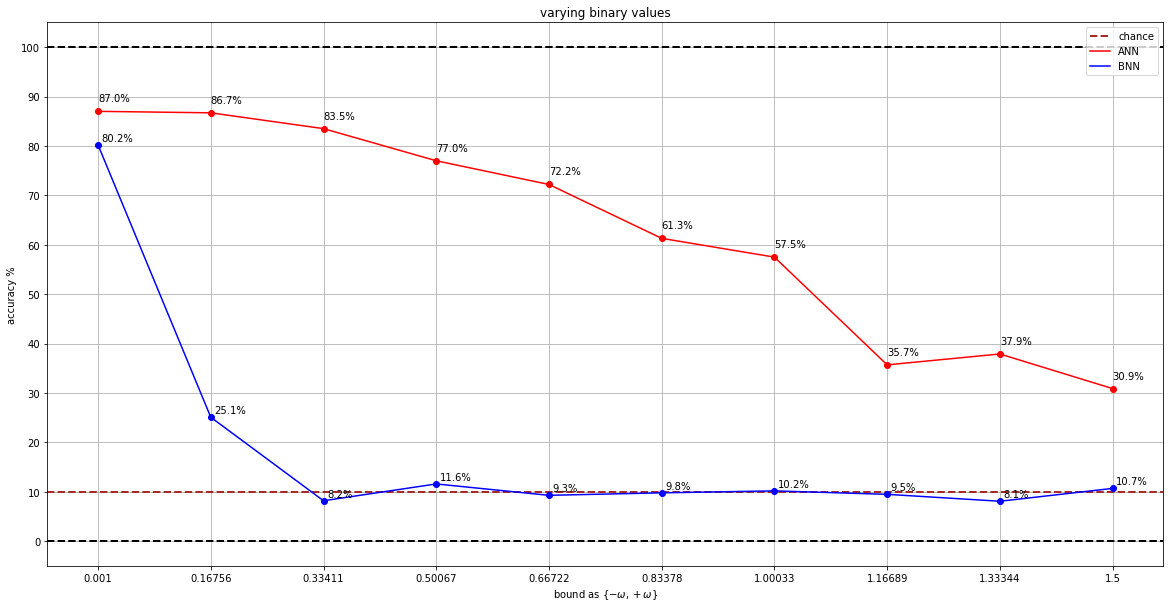

In [ ]:
fig = plt.figure(figsize=(20, 10))

plt.axhline(100, color='black', linestyle='--', linewidth=2)
plt.axhline(0, color='black', linestyle='--', linewidth=2)
#plt.axvline(0, color='black', linestyle='--', linewidth=2)
plt.axhline(10, color='brown', linestyle='--', linewidth=2, label='chance')

plt.plot(bound_set, accuracies_ann, '-r', label='ANN')
plt.plot(bound_set, accuracies_bnn, '-b', label='BNN')

plt.plot(bound_set, accuracies_ann, 'or')
plt.plot(bound_set, accuracies_bnn, 'ob')

for x, ya, yb in zip(bound_set, accuracies_ann, accuracies_bnn):
    plt.annotate(f'{ya}%', xy=(x, ya+2), textcoords='data')
    plt.annotate(f'{yb}%', xy=(x+0.005, yb+0.8), textcoords='data')
        
plt.legend(loc='upper right')
plt.title('varying binary values')
plt.xticks(bound_set, (bound_set))
plt.yticks(range(0, 105, 10))
plt.xlabel('bound as {$-\omega, +\omega$}')
plt.ylabel('accuracy %')
plt.ylim((-5, 105))

plt.grid()
plt.show()

Varying beta

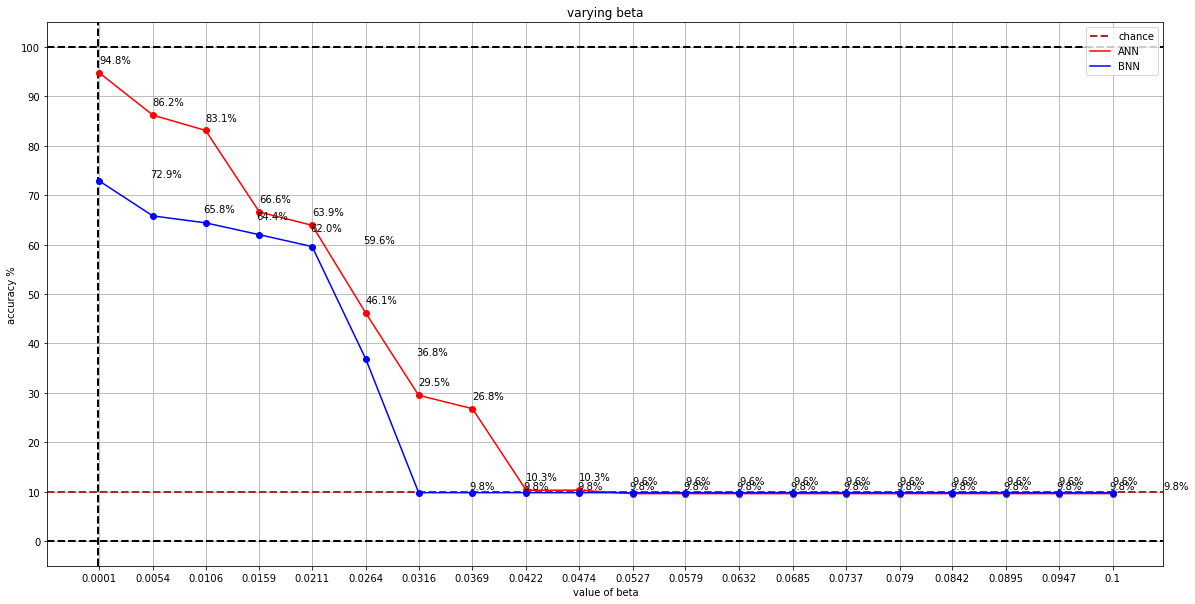

In [ ]:
beta_set = np.around(np.linspace(0.0001, 0.1, 20), 4)

n = len(beta_set)
accuracies_ann = np.zeros(n)
accuracies_bnn = np.zeros(n)

for i, beta in enumerate(beta_set):
    
    print(f'processed {100*i/n:.1f}%')
    mod_a = ANN_3(dim_in=ni, dim_hid=nh, dim_out=no, lr=0.001, beta=beta, omega=0.001, activation='tanh', shift=True)
    mod_a.train(epochs=5, display=False, verbose=False)
    
    mod_b = BNN(ann_params=mod_a.get_parameters(), amax=False)
    
    accuracies_ann[i] = mod_a.accuracy()
    accuracies_bnn[i] = mod_b.accuracy()
    
    clear_output(wait=True)

###########################################

fig = plt.figure(figsize=(20, 10))

plt.axhline(100, color='black', linestyle='--', linewidth=2)
plt.axhline(0, color='black', linestyle='--', linewidth=2)
plt.axvline(0, color='black', linestyle='--', linewidth=2)
plt.axhline(10, color='brown', linestyle='--', linewidth=2, label='chance')

plt.plot(beta_set, accuracies_ann, '-r', label='ANN')
plt.plot(beta_set, accuracies_bnn, '-b', label='BNN')

plt.plot(beta_set, accuracies_ann, 'or')
plt.plot(beta_set, accuracies_bnn, 'ob')

for x, ya, yb in zip(beta_set, accuracies_ann, accuracies_bnn):
    plt.annotate(f'{ya}%', xy=(x, ya+2), textcoords='data')
    plt.annotate(f'{yb}%', xy=(x+0.005, yb+0.8), textcoords='data')
        
plt.legend(loc='upper right')
plt.title('varying beta')
plt.xticks(beta_set, beta_set)
plt.yticks(range(0, 105, 10))
plt.xlabel('value of beta')
plt.ylabel('accuracy %')
plt.ylim((-5, 105))

plt.grid()
plt.show()

## ANN 3b

it uses another definition for R

$R \doteq sign(W - |\nabla L|)\odot \phi (\omega - W)$

In [7]:
class ANN_3b:
    def __init__(self, dim_in, dim_hid, dim_out, lr, beta=0.5, omega=6., activation='sigmoid', shift=True):
        
        # hyperparameters:
        self.dim_in = dim_in
        self.dim_hid = dim_hid
        self.dim_out = dim_out
        self.lr = lr
        
        self.set_activation(activation)    
        
        # parameters:
        self.weightsIH = (np.random.binomial(1, 0.5, size=(self.dim_hid, self.dim_in)).astype(float) - 0.5) / 5
        self.weightsHO = (np.random.binomial(1, 0.5, size=(self.dim_out, self.dim_hid)).astype(float) - 0.5) / 5
        
        # variables
        self.x  = np.zeros(self.dim_in)
        
        self.zh = np.zeros(self.dim_hid)
        self.ah = np.zeros(self.dim_hid)
        
        self.zo = np.zeros(self.dim_out)
        self.ao = np.zeros(self.dim_out)
        
        self.loss = np.zeros(self.dim_out)
        self.lossDo = np.zeros(self.dim_out)
        self.lossDh = np.zeros(self.dim_hid)
        
        # loss
        self.beta = beta
        self.omega = omega
        
        self.gradIH = np.zeros_like(self.weightsIH)
        self.gradHO = np.zeros_like(self.weightsHO)
        
        # targets
        if shift:
            self.y_train = ytrain_neg
        else:
            self.y_train = ytrain
            
        # other logs
        self.ratio_h = 0
        self.ratio_o = 0
            
        
    def set_activation(self, flag='sigmoid'):
        
        if flag == 'sigmoid':
            self.activation_function = lambda x: 1 / (1 + np.exp(-x))
            self.activation_function_prime = lambda x: self.activation_function(x) * (0.05 - self.activation_function(x))
        
        elif flag == 'tanh':
            self.activation_function = lambda x: 2 / (1 + np.exp(-x)) - 1
            self.activation_function_prime = lambda x: 1 - self.activation_function(x) ** 2
            
        elif flag == 'bounded':
            self.activation_function = lambda x: np.clip(x, -self.omega, self.omega)
            self.activation_function_prime = np.vectorize(lambda x: 1*(-self.omega < x and x < self.omega))
            
        else:
            self.activation_function = lambda x: x
            self.activation_function_prime = lambda x: x
    
    
    def get_parameters(self):
        return {'IH': self.weightsIH,
                'HO': self.weightsHO,
                'shape': (self.dim_in, self.dim_hid, self.dim_out)}
    
        
    def forward(self, X):
        self.x = X.T

        self.zh = np.dot(self.weightsIH, self.x)
        self.ah = self.activation_function(self.zh)
        self.zo = np.dot(self.weightsHO, self.ah)
        self.ao = self.activation_function(self.zo)
        
    
    def bound_function(self, u):
        #return self.bound / (1 + np.exp(-u)) - self.bound / 2
        #return np.clip(u, -self.bound, self.bound)
        #return self.bound*2 / (1 + 100*np.exp(-100*u)) - self.bound
        #return self.bound / (1 + 100*np.exp(-9*u/self.bound)) 
        return u
    
    def backward(self, Y):

        # losses
        self.loss = (Y - self.ao) ** 2
        
        self.lossDo = (self.ao - Y) * self.activation_function_prime(self.zo)
        self.lossDh = np.dot(self.weightsHO.T, np.reshape(self.lossDo, (self.dim_out, batch_size))) * np.reshape(
            self.activation_function_prime(self.zh), (self.dim_hid, batch_size))
        
        # gradients
        self.gradIH = np.dot(self.lossDh, self.x.T)
        self.gradHO = np.dot(self.lossDo, self.ah.T)
        
        
        # updates
        self.weightsIH -= self.lr * self.gradIH - self.beta * np.sign(self.weightsIH - self.gradIH
                                            ) * self.bound_function(self.omega - np.abs(self.weightsIH))

        self.weightsHO -= self.lr * self.gradHO - self.beta * np.sign(self.weightsHO - self.gradHO
                                            ) * self.bound_function(self.omega - np.abs(self.weightsHO))

        
        
    def show_w(self, epoch, acc, binary=False):

        clear_output(wait=True)

        names = ('IH', 'HO')
        plt.clf()
        for j, col in enumerate((self.weightsIH, self.weightsHO)):

            plt.subplot(1, 2, j+1)
            n, bins, patches = plt.hist(col.flatten(), bins=50, density=True, facecolor='g', alpha=0.75)


            plt.xlabel(f'weights {names[j]}')
        

            plt.axis([-self.bound-0.4, self.bound+0.4, 0, 20.])
            if j == 1:
                plt.yticks(())
            
            else:
                plt.ylabel('quantity')
                
        plt.title(f'test accuracy: {acc}%')
            
        plt.pause(0.00001)
        
    def get_ratio(self, W):
        return np.mean([ np.sum(np.where(node>=0, 1, 0)) for node in W]
                 ) / np.mean([ np.sum(np.where(node<0, 1, 0)) for node in W])
    
        
    def accuracy(self):
                
        corrects = 0
        for x, y in zip(xtest, ytest):
            self.forward(np.sign(x))
            corrects += np.mean(y == np.argmax(self.ao, axis=0))
            
        return np.around(100*corrects/len(xtest), 1)
    
    def show_ratio(self, rh, ro):
        clear_output(wait=True)
        plt.clf()
        plt.axhline(1, linestyle='--', color='grey', alpha=0.5)
        plt.plot(range(len(rh)), rh, '-b', label=f'hidden layer {rh[-1]:.4f}')
        plt.plot(range(len(ro)), ro, '-g', label=f'output layer {ro[-1]:.4f}')
        plt.plot(range(len(self.accs)), self.accs/100, '-r', label=f'accuracy {self.accs[-1]:.2f}')
        plt.ylim((0.5, 1.5))
        plt.legend(loc='upper right')
        plt.title('average ratio per node of positive/negative weights')
        plt.xlabel('epochs')
        plt.ylabel('ratio')
        plt.pause(0.00001)
        
        
    def train(self, epochs=1, display=False, display_ratio=False, verbose=True):        
        
        # pre-training accuracy        
        pre_acc = self.accuracy()
        
        ''' training '''
        
        losses = []
        test_acc = 0
        
        self.accs = [0.0]
        self.concs1  = []
        self.concs2 = []
        
        r_h = [self.get_ratio(self.weightsIH)]
        r_o = [self.get_ratio(self.weightsHO)]
        
        self.pop_h = []
        self.pop_o = []
        self.pop_n = []
        
        block = False
        for epoch in range(epochs):
            
            
            for i, x, y in zip(range(len(xtrain)), xtrain, self.y_train):
                
                self.forward(np.sign(x))
                self.backward(y.T)
                    
                if i%100 == 0 and not display and verbose:
                    clear_output(wait=True)
                    print(f'epoch: {epoch+1}|{epochs}\ntest accuracy: {test_acc}%')
                    print(f'\ndata {100*i/len(xtrain):.0f}%')
                    
                if display and i%100 == 0:
                    self.show_w(epoch+1, test_acc)
                    
            if display_ratio:
                self.show_ratio(r_h, r_o)
                        
            losses.append(np.mean(self.loss))
            
            
            ''' test '''
            
            test_acc = self.accuracy()  
            self.accs.append(test_acc)
            
            r_h.append(self.get_ratio(self.weightsIH))
            r_o.append(self.get_ratio(self.weightsHO))
            
            self.concs1.append(concordance(self.ah)*100)
            self.concs2.append(concordance(self.ao)*100) 
            
            self.pop_h.append(np.mean(np.mean(np.abs(self.ah), axis=0)))
            self.pop_o.append(np.mean(np.mean(np.abs(self.ao), axis=0)))
            self.pop_n.append((self.pop_h[-1]+self.pop_o[-1])/2)
            
        # final logs
        self.ratio_h = r_h[-1]
        self.ratio_o = r_o[-1]
           
        if verbose:
            clear_output(wait=True)
            print('\nTRAINING ENDED\n')
            print('epochs done: {}\n\nANN accuracy: {}%'.format(epochs, test_acc))                  
    

In [8]:
ni, no = 784, 10

ann_3b = ANN_3b(dim_in=ni, dim_hid=50, dim_out=no, lr=0.001, beta=0.001, omega=1., activation='tanh', shift=True)

''' run '''

ann_3b.train(epochs=30, display=0, display_ratio=0, verbose=1)


''' binarized '''

bnn_3b = BNN(ann_params=ann_3b.get_parameters(), amax=False)

print(f'BNN accuracy: {bnn_3b.accuracy()}%')


TRAINING ENDED

epochs done: 30

ANN accuracy: 90.2%
BNN accuracy: 75.7%


#### Plots the weights of the ANN 3b

In [9]:
def weights_matrix(model, name):
    print(f'model: {name}')
    
    fig, (ax1, ax2) = plt.subplots(figsize=(15, 5), nrows=2)
    
    ax1.imshow(model.weightsIH, cmap='Greys')
    ax1.set_title('hidden weights')
    ax1.set_xticks(())
    ax1.set_yticks(())
    
    ax2.imshow(model.weightsHO, cmap='Greys')
    ax2.set_title('output weights')
    ax2.set_xticks(())
    ax2.set_yticks(())
    
    plt.show()

model: ANN 3B


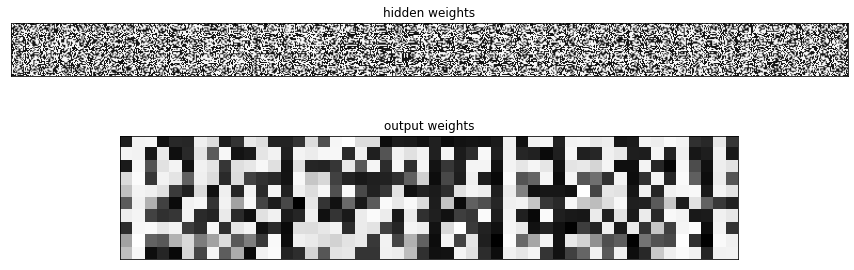

In [10]:
weights_matrix(model=ann_3b, name='ANN 3B')

## ANN 3 vs ANN 3b

In [ ]:
nh = 49

bound_set = np.around(np.linspace(0.001, 1.5, 10), 5)
n = len(bound_set)

accuracies_ann = np.zeros(n)
accuracies_bnn = np.zeros(n)

accuracies_ann_b = np.zeros(n)
accuracies_bnn_b = np.zeros(n)

for i, bound in enumerate(bound_set):
    
    print(f'processed {100*i/n:.1f}%')
    
    # ann 3 ##########################
    mod_a = ANN_3(dim_in=ni, dim_hid=nh, dim_out=no, lr=0.001, beta=0.005, omega=bound, activation='tanh', shift=True)
    mod_a.train(epochs=5, display=False, verbose=False)
    
    mod_b = BNN(ann_params=mod_a.get_parameters())
    
    accuracies_ann[i] = mod_a.accuracy()
    accuracies_bnn[i] = mod_b.accuracy()
    
    # ann 3b ##########################
    mod_ab = ANN_3b(dim_in=ni, dim_hid=nh, dim_out=no, lr=0.001, beta=0.005, omega=bound, activation='tanh', shift=True)
    mod_ab.train(epochs=5, display=False, verbose=False)
    
    mod_bb = BNN(ann_params=mod_ab.get_parameters(), amax=False)
    
    accuracies_ann_b[i] = mod_ab.accuracy()
    accuracies_bnn_b[i] = mod_bb.accuracy()
    
    
    clear_output(wait=True)

print('\nprocess terminated')


process terminated


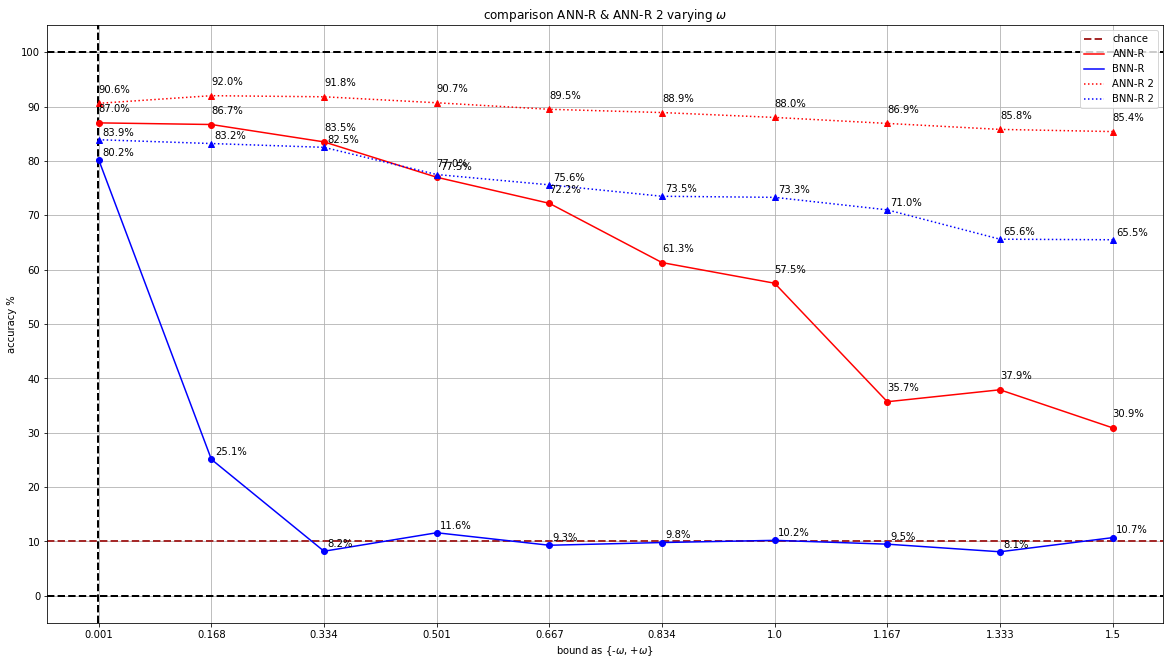

In [ ]:
fig = plt.figure(figsize=(20, 11))

plt.axhline(100, color='black', linestyle='--', linewidth=2)
plt.axhline(0, color='black', linestyle='--', linewidth=2)
plt.axvline(0, color='black', linestyle='--', linewidth=2)
plt.axhline(10, color='brown', linestyle='--', linewidth=2, label='chance')

# ann 3
plt.plot(bound_set, accuracies_ann, '-r', label='ANN-R')
plt.plot(bound_set, accuracies_bnn, '-b', label='BNN-R')

plt.plot(bound_set, accuracies_ann, 'or')
plt.plot(bound_set, accuracies_bnn, 'ob')

for x, ya, yb in zip(bound_set, accuracies_ann, accuracies_bnn):
    plt.annotate(f'{ya}%', xy=(x, ya+2), textcoords='data')
    plt.annotate(f'{yb}%', xy=(x+0.005, yb+0.8), textcoords='data')
    
# ann 3b
plt.plot(bound_set, accuracies_ann_b, ':r', label='ANN-R 2')
plt.plot(bound_set, accuracies_bnn_b, ':b', label='BNN-R 2')

plt.plot(bound_set, accuracies_ann_b, '^r')
plt.plot(bound_set, accuracies_bnn_b, '^b')

for x, ya, yb in zip(bound_set, accuracies_ann_b, accuracies_bnn_b):
    plt.annotate(f'{ya}%', xy=(x, ya+2), textcoords='data')
    plt.annotate(f'{yb}%', xy=(x+0.005, yb+0.8), textcoords='data')
        
plt.legend(loc='upper right')
plt.title('comparison ANN-R & ANN-R 2 varying $\omega$')
plt.xticks(bound_set, np.around(bound_set, 3))
plt.yticks(range(0, 105, 10))
plt.xlabel('bound as {-$\omega$, +$\omega$}')
plt.ylabel('accuracy %')
plt.ylim((-5, 105))

plt.grid()

### ANN 3B: changing hidden size

In [ ]:
hidden_sizes = np.arange(2, 15, 1)
n = len(hidden_sizes)
accuracies_ann = np.zeros(n)
accuracies_bnn = np.zeros(n)

for i, hsize in enumerate(hidden_sizes):
    
    print(f'processed {100*i/n:.1f}%')
    mod_a = ANN_3b(dim_in=ni, dim_hid=hsize**2, dim_out=no, lr=0.001, beta=0.002, omega=1., activation='tanh', shift=True)
    mod_a.train(epochs=10, display=False, verbose=False)
    
    mod_b = BNN(ann_params=mod_a.get_parameters(), amax=False)
    
    accuracies_ann[i] = mod_a.accuracy()
    accuracies_bnn[i] = mod_b.accuracy()
    
    clear_output(wait=True)

print('\nprocess terminated')


process terminated


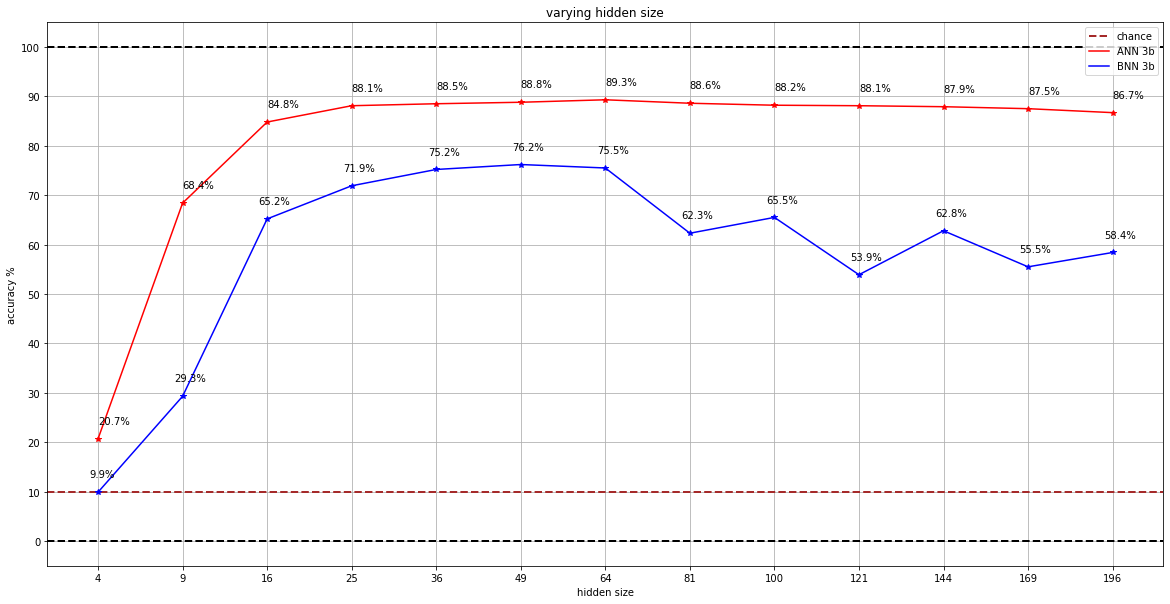

In [ ]:
fig = plt.figure(figsize=(20, 10))

plt.axhline(100, color='black', linestyle='--', linewidth=2)
plt.axhline(0, color='black', linestyle='--', linewidth=2)
#plt.axvline(2, color='black', linestyle='--', linewidth=2)
plt.axhline(10, color='brown', linestyle='--', linewidth=2, label='chance')

plt.plot(hidden_sizes, accuracies_ann, '-r', label='ANN 3b')
plt.plot(hidden_sizes, accuracies_bnn, '-b', label='BNN 3b')

plt.plot(hidden_sizes, accuracies_ann, '*r')
plt.plot(hidden_sizes, accuracies_bnn, '*b')

for x, ya, yb in zip(hidden_sizes, accuracies_ann, accuracies_bnn):
    plt.annotate(f'{ya}%', xy=(x, ya+3), textcoords='data')
    plt.annotate(f'{yb}%', xy=(x-0.1, yb+3), textcoords='data')
        
plt.legend(loc='upper right')
plt.title('varying hidden size')
plt.xticks(hidden_sizes, hidden_sizes**2)
plt.yticks(range(0, 105, 10))
plt.xlabel('hidden size')
plt.ylabel('accuracy %')
plt.ylim((-5, 105))

plt.grid()
plt.show()

### varying hidden size and beta

In [11]:
hidden_sizes = np.arange(2, 15, 1)
beta_set = np.linspace(0.0001, 0.1, len(hidden_sizes))
n = len(hidden_sizes)

accuracies_ann = np.zeros((n, n))
accuracies_bnn = np.zeros((n, n))

t = 0
for i, hsize in enumerate(hidden_sizes):
    for j, beta in enumerate(beta_set):
    
        print(f'processed {100*t/(n*n):.1f}%')
        
        mod_a = ANN_3b(dim_in=784, dim_hid=hsize**2, dim_out=10, lr=0.001, beta=beta, omega=1., activation='tanh', shift=True)
        mod_a.train(epochs=10, display=False, verbose=False)

        mod_b = BNN(ann_params=mod_a.get_parameters(), amax=False)

        accuracies_ann[i, j] = mod_a.accuracy()
        accuracies_bnn[i, j] = mod_b.accuracy()

        clear_output(wait=True)
        t += 1

print('\nprocess terminated')


process terminated


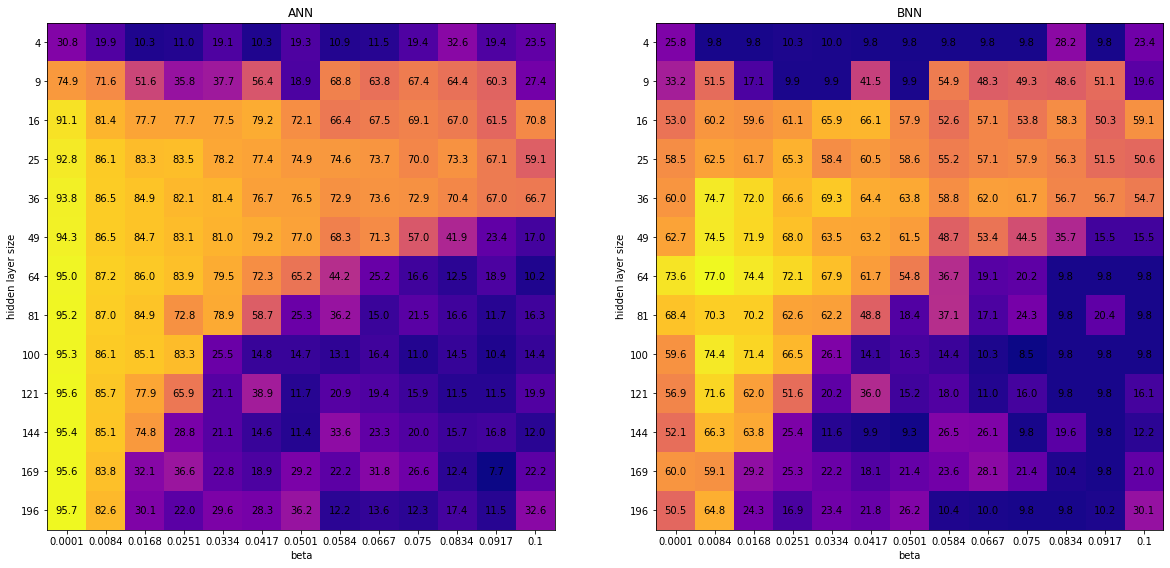

In [18]:
fig, (ax1, ax2) = plt.subplots(figsize=(20, 20), ncols=2)

ax1.imshow(accuracies_ann, cmap='plasma')
ax1.set_ylabel('hidden layer size')
ax1.set_yticks(range(n))
ax1.set_yticklabels(hidden_sizes**2)

ax1.set_xlabel('beta')
ax1.set_xticks(range(n))
ax1.set_title('ANN')
ax1.set_xticklabels(np.around(beta_set, 4))

for (i, j), f in np.ndenumerate(accuracies_ann):
    ax1.text(j, i, f'{f:.1f}', ha='center', va='center')
    
##

ax2.imshow(accuracies_bnn, cmap='plasma')
ax2.set_ylabel('hidden layer size')
ax2.set_yticks(range(n))
ax2.set_yticklabels(hidden_sizes**2)

ax2.set_xlabel('beta')
ax2.set_xticks(range(n))
ax2.set_title('BNN')
ax2.set_xticklabels(np.around(beta_set, 4))

for (i, j), f in np.ndenumerate(accuracies_bnn):
    ax2.text(j, i, f'{f:.1f}', ha='center', va='center')

    
plt.show()

# Analysis on ANN 3b 
omega = +- 1.0

### ratio positive/negative weights per node

In [ ]:
# weights
wh, wo = ann_3b.weightsIH, ann_3b.weightsHO

print(f'wh shape: {wh.shape}\nwo shape: {wo.shape}')

wh shape: (50, 784)
wo shape: (10, 50)


average per node

In [ ]:
print('- hidden layer -')
print('average ratio positive/negative weights per hidden node: ', end='')

ratio_h = np.mean([ np.sum(np.where(node>=0, 1, 0)) for node in wh]
                 ) / np.mean([ np.sum(np.where(node<0, 1, 0)) for node in wh])

print(f'{ratio_h:.6f}')

print('\n- output layer -')
print('average ratio positive/negative weights per output node: ', end='')

ratio_o = np.mean([ np.sum(np.where(node>=0, 1, 0)) for node in wo]
                 ) / np.mean([ np.sum(np.where(node<0, 1, 0)) for node in wo])

print(f'{ratio_o:.6f}')

- hidden layer -
average ratio positive/negative weights per hidden node: 0.992477

- output layer -
average ratio positive/negative weights per output node: 0.992032


distribution of the average over many samples

In [ ]:
n = 30
ratio_h, ratio_o = [], []

for i in range(n):
    net = ANN_3b(dim_in=ni, dim_hid=50, dim_out=no, lr=0.001, beta=0.001,
                 bound=1., activation='tanh', shift=True)
    net.train(epochs=7, display=0, display_ratio=0, verbose=0)
    
    ratio_h.append(net.ratio_h)
    ratio_o.append(net.ratio_o)
    
    print(f'processed {100*(i+1)/n:.1f}%')
    clear_output(wait=True)
    
print(f'results obtained over {n} samples\n')
print('- hidden layer -')
print(f'mean: {np.mean(ratio_h):.3f}\nstdv: {np.std(ratio_h):.3f}')
print('\n- output layer -')
print(f'mean: {np.mean(ratio_o):.3f}\nstdv: {np.std(ratio_o):.3f}')

results obtained over 30 samples

- hidden layer -
mean: 1.002
stdv: 0.010

- output layer -
mean: 0.950
stdv: 0.125


concordance condition over epochs

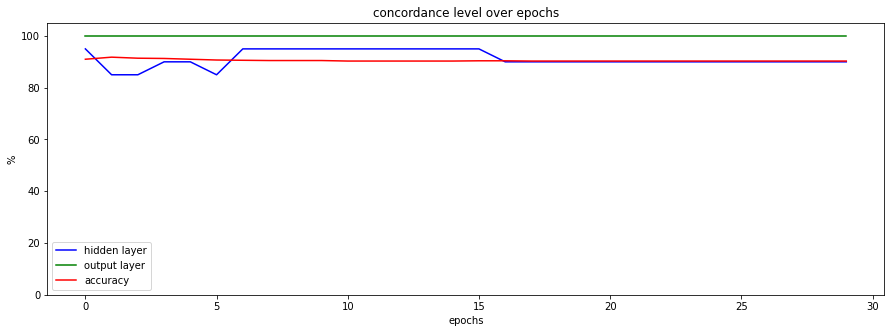

In [ ]:
fig = plt.figure(figsize=(15, 5))
plt.plot(range(len(ann_3b.concs1)), ann_3b.concs1, '-b', label='hidden layer')
plt.plot(range(len(ann_3b.concs2)), ann_3b.concs2, '-g', label='output layer')
plt.plot(range(len(ann_3b.accs)), ann_3b.accs, '-r', label='accuracy')
plt.xlabel('epochs')
plt.ylabel('%')
plt.ylim((0, 105))
plt.title('concordance level over epochs')
plt.legend()
plt.show()

average activity over epochs

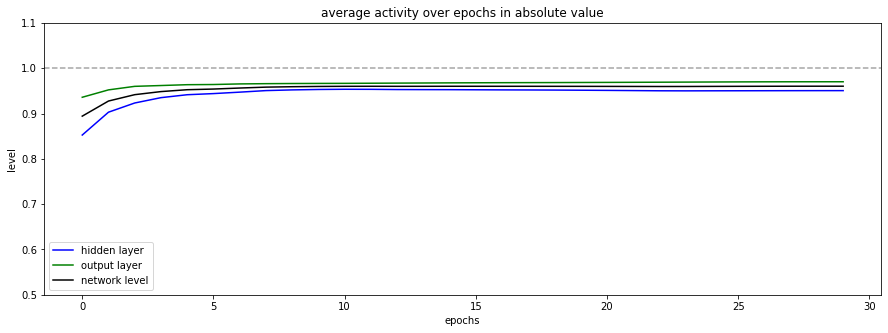

In [ ]:
fig = plt.figure(figsize=(15, 5))

plt.axhline(1, linestyle='--', color='grey', alpha=0.7)
plt.plot(range(len(ann_3b.pop_h)), ann_3b.pop_h, '-b', label='hidden layer')
plt.plot(range(len(ann_3b.pop_o)), ann_3b.pop_o, '-g', label='output layer')
plt.plot(range(len(ann_3b.pop_n)), ann_3b.pop_n, '-k', label='network level')
#plt.plot(range(len(ann_3b.accs)), ann_3b.accs, '-r', label='accuracy')

plt.xlabel('epochs')
plt.ylabel('level')
plt.ylim((0.5, 1.1))
plt.title('average activity over epochs in absolute value')
plt.legend()
plt.show()